In [11]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter

import matplotlib.colors as mcolors
custom_colors = ["white", "#DA8A67", "#A0522D", "#400000"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot", custom_colors)


def gettingFacets(filename,includeCoat='true'):
    exe = ["./getFacet", filename, includeCoat]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    segs = []
    skip = False
    if (len(temp2) > 1e2):
        for n1 in range(len(temp2)):
            temp3 = temp2[n1].split(" ")
            if temp3 == ['']:
                skip = False
                pass
            else:
                if not skip:
                    temp4 = temp2[n1+1].split(" ")
                    r1, z1 = np.array([float(temp3[1]), float(temp3[0])])
                    r2, z2 = np.array([float(temp4[1]), float(temp4[0])])
                    segs.append(((r1, z1),(r2, z2)))
                    segs.append(((-r1, z1),(-r2, z2)))
                    skip = True
    return segs

def gettingfield(filename, zmin, zmax, rmax, nr):
    exe = ["./getData-elastic-scalar", filename, str(zmin), str(0), str(zmax), str(rmax), str(nr)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, D2temp, veltemp, taupTemp  = [],[],[],[],[]

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            D2temp.append(float(temp3[2]))
            veltemp.append(float(temp3[3]))
            taupTemp.append(float(temp3[4]))

    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    D2 = np.asarray(D2temp)
    vel = np.asarray(veltemp)
    taup = np.asarray(taupTemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    D2.resize((nz, nr))
    vel.resize((nz, nr))
    taup.resize((nz, nr))

    return R, Z, D2, vel, taup, nz
# ----------------------------------------------------------------------------------------------------------------------

def process_timestep(t, caseToProcess, folder, GridsPerR, rmin, rmax, zmin, zmax, lw):
    place = f"{caseToProcess}/intermediate/snapshot-{t:.4f}"
    name = f"{folder}/{int(t*1000):08d}.png"

    if not os.path.exists(place):
        print(f"{place} File not found!")
        return

    if os.path.exists(name):
        print(f"{name} Image present!")
        return

    segs1 = gettingFacets(place)
    segs2 = gettingFacets(place, 'false')

    if not segs1 and not segs2:
        print(f"Problem in the available file {place}")
        return

    nr = int(GridsPerR * rmax)
    R, Z, taus, vel, taup, nz = gettingfield(place, zmin, zmax, rmax, nr)
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

    # Plotting
    AxesLabel, TickLabel = 50, 20
    fig, ax = plt.subplots()
    fig.set_size_inches(19.20, 10.80)

    ax.plot([0, 0], [zmin, zmax], '-.', color='grey', linewidth=lw)
    ax.plot([rmin, rmin], [zmin, zmax], '-', color='black', linewidth=lw)
    ax.plot([rmin, rmax], [zmin, zmin], '-', color='black', linewidth=lw)
    ax.plot([rmin, rmax], [zmax, zmax], '-', color='black', linewidth=lw)
    ax.plot([rmax, rmax], [zmin, zmax], '-', color='black', linewidth=lw)

    line_segments = LineCollection(segs2, linewidths=4, colors='green', linestyle='solid')
    ax.add_collection(line_segments)
    line_segments = LineCollection(segs1, linewidths=4, colors='green', linestyle='solid')
    ax.add_collection(line_segments)

    cntrl1 = ax.imshow(taup, cmap="coolwarm", interpolation='Bilinear', origin='lower', extent=[-rminp, -rmaxp, zminp, zmaxp], vmax=1.0, vmin=-1.0)

    cntrl2 = ax.imshow(vel, interpolation='Bilinear', cmap='Blues', origin='lower', extent=[rminp, rmaxp, zminp, zmaxp], vmax=2.0, vmin=0.0)

    ax.set_aspect('equal')
    ax.set_xlim(rmin, rmax)
    ax.set_ylim(zmin, zmax)
    ax.set_title(f't = {t:4.3f}', fontsize=TickLabel)

    l, b, w, h = ax.get_position().bounds
    # Left colorbar
    cb1 = fig.add_axes([l-0.04, b, 0.03, h])
    c1 = plt.colorbar(cntrl1, cax=cb1, orientation='vertical')
    c1.set_label(r'log(A)', fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)
    c1.ax.yaxis.set_ticks_position('left')
    c1.ax.yaxis.set_label_position('left')
    c1.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    
    # Right colorbar
    cb2 = fig.add_axes([l+w+0.01, b, 0.03, h])
    c2 = plt.colorbar(cntrl2, cax=cb2, orientation='vertical')
    c2.ax.tick_params(labelsize=TickLabel)
    c2.set_label(r'||u||', fontsize=TickLabel)
    c2.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    ax.axis('off')
    plt.show()

    # plt.savefig(name, bbox_inches="tight")
    # plt.close()

nz is 256


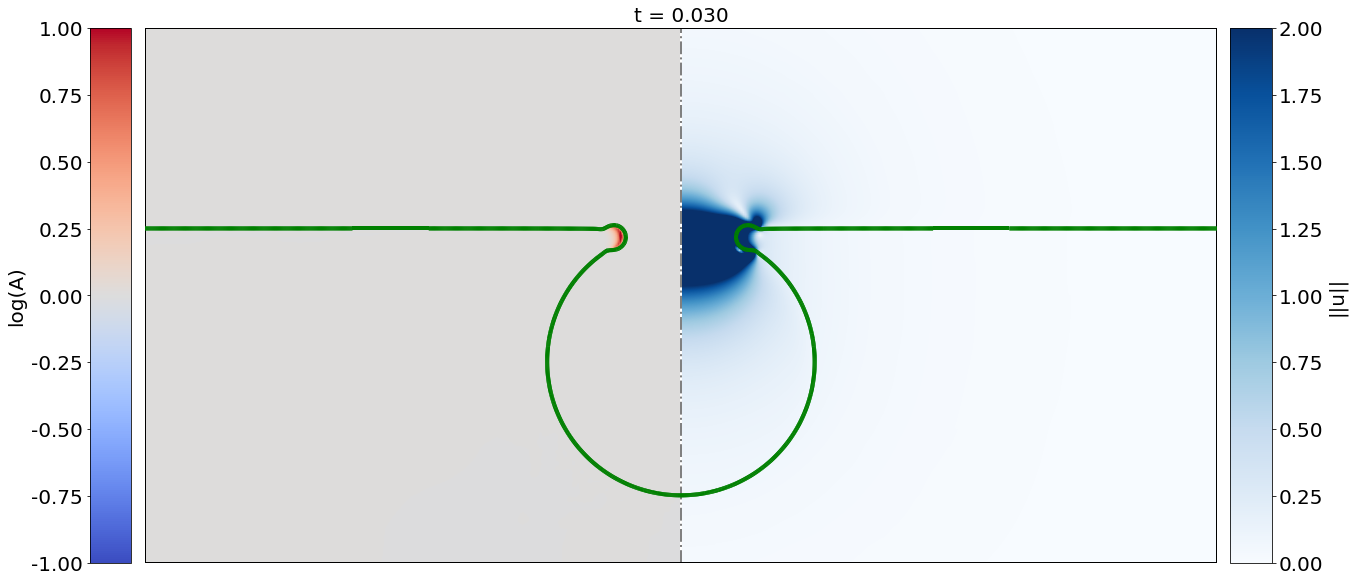

In [12]:
process_timestep(t = 0.03, caseToProcess="../testCases/4-BurstingBubbles-WithPolymers", folder="Video", GridsPerR=64, rmin=-4.0, rmax=4.0, zmin=-2.5, zmax=1.5, lw=2)